In [52]:
import os
from pathlib import Path
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
folder = Path(cwd) / '../code/output'
if (not folder.is_dir()):
    print(f'ERROR: {folder} is not a folder.')
print(f'The Current Working Directory (CWD) is {cwd}')
print(f'The output folder is {folder}')

The Current Working Directory (CWD) is /Users/jameskeaveney/Teaching_resources/Teaching/PHY5007Z_DataScience/UCT-DS-Project-picoPT/notebooks
The output folder is /Users/jameskeaveney/Teaching_resources/Teaching/PHY5007Z_DataScience/UCT-DS-Project-picoPT/notebooks/../code/output


In [53]:
filename = os.path.join(folder, "output_picopet.root")
f = uproot.open(filename)

# print the list of trees
for t in f:
    print(f'Tree {t}')

# get the first tree and print the branches
hits = f['Singles1']

df = f['Singles1'].arrays(["PostPosition_X", "PostPosition_Y", "PostPosition_Z", "TotalEnergyDeposit",  "GlobalTime", "LocalTime"], library="pd")

print(f'Number of hits : {hits.num_entries}')
for b in hits:
    print(f'Branch {b.name}')

df.head()

Tree Hits;1
Tree Singles1;1
Tree Singles2;1
Tree Singles3;1
Tree Singles4;1
Tree Singles5;1
Number of hits : 1891210.0
Branch PostPosition_X
Branch PostPosition_Y
Branch PostPosition_Z
Branch TotalEnergyDeposit
Branch PreStepUniqueVolumeID
Branch GlobalTime
Branch LocalTime


,PostPosition_X,PostPosition_Y,PostPosition_Z,TotalEnergyDeposit,GlobalTime,LocalTime
0,-229.852581,8.472961,10.0,0.510999,27.040770,0.788706
1,-91.484966,-211.107795,-14.0,0.510999,32.621175,0.641283
2,-228.242265,-30.091003,14.0,0.015573,44.081379,1.928329
3,100.897425,-206.774538,2.0,0.133792,84.505588,0.442412
4,-161.146457,164.413562,10.0,0.014903,85.388238,0.505703


In [54]:

import pandas as pd
import numpy as np

def find_coincidences(df: pd.DataFrame, time_window: float, 
                      energy_center: float = 0.511, delta_e: float = 0.3) -> pd.DataFrame:
    """
    Find photon coincidences within a time window and an energy window,
    with rejection of multiple coincidences (only accept exactly one partner photon).
    
    Prints how many multiple coincidences were rejected.
    
    Parameters:
        df (pd.DataFrame): Photon data with columns:
            ["PostPosition_X", "PostPosition_Y", "PostPosition_Z",
             "TotalEnergyDeposit", "GlobalTime", "LocalTime"]
        time_window (float): Time difference (same units as 'GlobalTime') for coincidences.
        energy_center (float): Center of the allowed energy window (default: 511 keV).
        delta_e (float): Half-width of energy window. Both photons must have energy in
                         [energy_center - delta_e, energy_center + delta_e].
        
    Returns:
        pd.DataFrame: DataFrame of coincidence pairs with suffixed columns.
    """
    # Sort by GlobalTime
    df_sorted = df.sort_values("GlobalTime").reset_index(drop=True)
    times = df_sorted["GlobalTime"].to_numpy()
    energy = df_sorted["TotalEnergyDeposit"].to_numpy()
    
    # Define energy bounds
    e_min = energy_center - delta_e
    e_max = energy_center + delta_e
    
    result_rows = []
    colnames = df.columns
    
    # Counters
    multiple_rejections = 0
    accepted_pairs = 0
    
    for i in range(len(df_sorted)):
        t0 = times[i]
        e0 = energy[i]
        
        if not (e_min <= e0 <= e_max):
            continue
        
        j_start = i + 1
        j_end = np.searchsorted(times, t0 + time_window, side='right')
        
        candidates = df_sorted.iloc[j_start:j_end]
        mask = (candidates["TotalEnergyDeposit"] >= e_min) & (candidates["TotalEnergyDeposit"] <= e_max)
        candidates = candidates[mask]
        
        # --- Multiple coincidence rejection ---
        if len(candidates) != 1:
            if len(candidates) > 1:
                multiple_rejections += 1  # Count suspected multiple coincidences
            continue  # Always skip if not exactly one candidate
        # --------------------------------------
        
        # Accept the single matching photon
        row2 = candidates.iloc[0]
        row1 = df_sorted.iloc[i]
        
        combined = [row1[col] for col in colnames] + [row2[col] for col in colnames]
        result_rows.append(combined)
        
        accepted_pairs += 1

    # Final dataframe
    columns = [f"{col}_1" for col in colnames] + [f"{col}_2" for col in colnames]
    coincidences_df = pd.DataFrame(result_rows, columns=columns)
    
    # Print summary
    print(f"Coincidence finding summary:")
    print(f"  Accepted pairs: {accepted_pairs}")
    print(f"  Rejected suspected multiple coincidences: {multiple_rejections}")
    
    return coincidences_df



In [55]:
time_window = 1.0  # example time window value... around 30cm diameter tansverse FOV
energy_half_range = 0.051 # 10% energy resolution assumed

coincidences_df = find_coincidences(df, time_window, delta_e= energy_half_range)

Coincidence finding summary:
  Accepted pairs: 82363
  Rejected suspected multiple coincidences: 5428


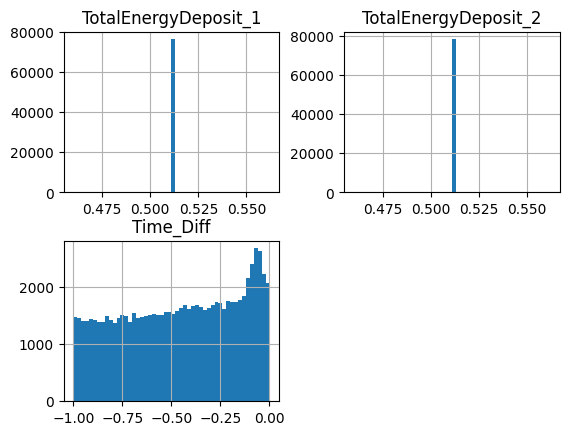

In [56]:
# Create a new DataFrame with algebraic combinations
df_new = pd.DataFrame({
    "Time_Diff": coincidences_df["GlobalTime_1"] - coincidences_df["GlobalTime_2"],
    "TotalEnergyDeposit_1": coincidences_df["TotalEnergyDeposit_1"],
    "TotalEnergyDeposit_2": coincidences_df["TotalEnergyDeposit_2"]
})

hist = df_new.hist(column=['TotalEnergyDeposit_1', 'TotalEnergyDeposit_2','Time_Diff'],bins=50)

In [57]:
from matplotlib.collections import LineCollection

def plot_physical_positions(coincidences_df: pd.DataFrame):
    """
    Plot physical positions of coincidence pairs in the x-y plane using vectorized drawing.
    
    For each coincidence pair, the two positions are plotted as small semi-transparent dots,
    and a semi-transparent red line is drawn connecting them. This version uses vectorized
    operations (via a LineCollection and bulk scatter) to dramatically speed up plotting
    for large numbers of pairs.
    
    Parameters:
        coincidences_df (pd.DataFrame): DataFrame with coincidence pairs,
            containing at least the columns:
                'PostPosition_X_1', 'PostPosition_Y_1',
                'PostPosition_X_2', 'PostPosition_Y_2'.
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Extract the arrays of coordinates.
    x1 = coincidences_df["PostPosition_X_1"].values
    y1 = coincidences_df["PostPosition_Y_1"].values
    x2 = coincidences_df["PostPosition_X_2"].values
    y2 = coincidences_df["PostPosition_Y_2"].values

    # Build an array of segments for the red lines.
    # Each segment is defined as [[x1, y1], [x2, y2]]
    segments = np.stack([np.column_stack((x1, y1)), np.column_stack((x2, y2))], axis=1)

    # Create a LineCollection from all segments.
    line_collection = LineCollection(segments, colors='red', linewidths=0.5, alpha=0.08)
    ax.add_collection(line_collection)

    # Plot all blue dots at once.
    ax.scatter(x1, y1, color='blue', s=20, alpha=0.5, zorder=3)
    ax.scatter(x2, y2, color='blue', s=20, alpha=0.5, zorder=3)

    ax.set_xlabel("PostPosition_X")
    ax.set_ylabel("PostPosition_Y")
    ax.set_title("Coincidence Pairs: Physical Positions")

    plt.tight_layout()
    plt.show()

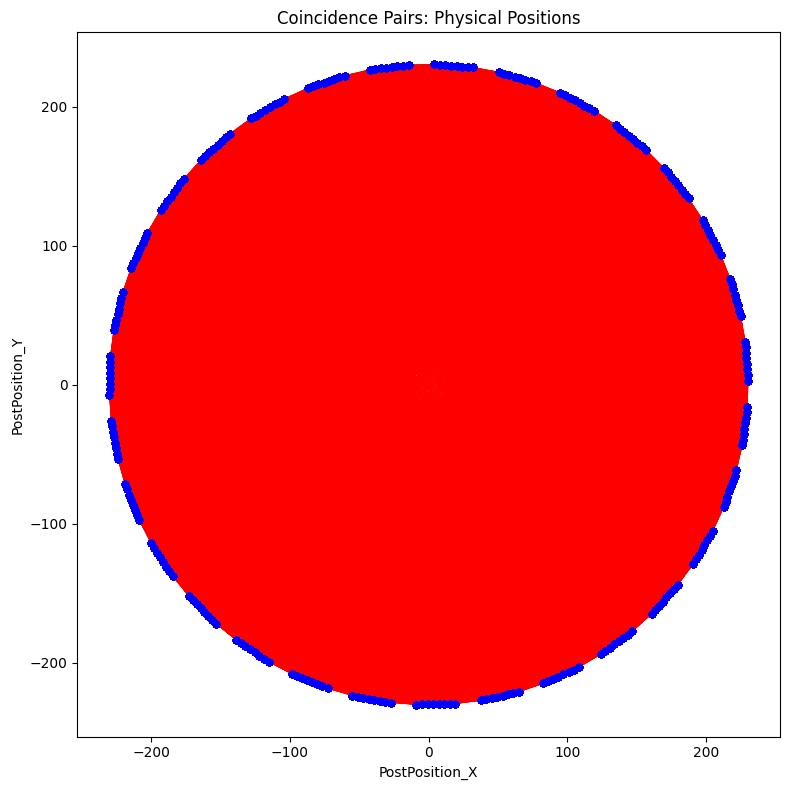

In [58]:
# Example usage:
# Assuming `coincidences_df` is your dataframe of coincidence pairs.
plot_physical_positions(coincidences_df)

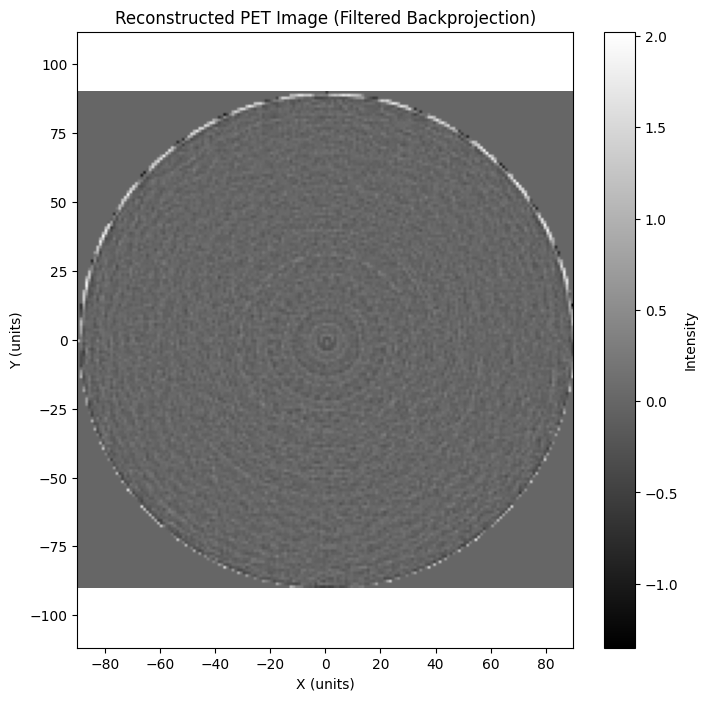

In [59]:
from skimage.transform import iradon

def compute_sinogram(coincidences_df: pd.DataFrame, bins_theta: int = 180, bins_r: int = 180):
    """
    Compute the sinogram from coincidence pairs.

    Each line-of-response (LOR) is parameterized by:
      - theta: the angle (in degrees) of the normal to the LOR (in [0,180))
      - r: the perpendicular distance from the origin to the LOR.

    Parameters:
      coincidences_df: DataFrame with coincidence pairs, containing columns:
         'PostPosition_X_1', 'PostPosition_Y_1',
         'PostPosition_X_2', 'PostPosition_Y_2'.
      bins_theta: Number of bins for theta (angles in degrees).
      bins_r: Number of bins for r (distance).

    Returns:
      sinogram: 2D numpy array (shape: [bins_r, bins_theta]).
      theta_centers: 1D array of theta bin centers (in degrees).
      r_edges: 1D array of r bin edges.
    """
    thetas = []
    rs = []

    for _, row in coincidences_df.iterrows():
        x1, y1 = row["PostPosition_X_1"], row["PostPosition_Y_1"]
        x2, y2 = row["PostPosition_X_2"], row["PostPosition_Y_2"]

        # Compute the midpoint of the LOR.
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0

        # Orientation of the LOR (angle of the line connecting the two points)
        phi = np.arctan2(y2 - y1, x2 - x1)

        # The sinogram parameter theta is the angle of the normal to the LOR.
        theta = (phi + np.pi/2) % np.pi  # in radians

        # r is the projection of the midpoint onto the normal.
        r = xm * np.cos(theta) + ym * np.sin(theta)

        thetas.append(theta)
        rs.append(r)

    thetas = np.array(thetas)
    rs = np.array(rs)

    # Convert theta from radians to degrees.
    thetas_deg = np.degrees(thetas)

    # Define histogram bin edges.
    theta_edges = np.linspace(0, 180, bins_theta + 1)
    r_min, r_max = rs.min(), rs.max()
    r_edges = np.linspace(r_min, r_max, bins_r + 1)

    # Create 2D histogram: rows are r bins, columns are theta bins.
    sinogram, _, _ = np.histogram2d(rs, thetas_deg, bins=[r_edges, theta_edges])

    # Compute theta bin centers.
    theta_centers = (theta_edges[:-1] + theta_edges[1:]) / 2.0

    return sinogram, theta_centers, r_edges

def reconstruct_pet_image(sinogram: np.ndarray, theta_centers: np.ndarray,
                          filter_name: str = 'ramp', output_size: int = None):
    """
    Reconstruct the PET image from a sinogram using filtered backprojection.

    Parameters:
      sinogram: 2D numpy array representing the sinogram (shape: [radial bins, angles]).
      theta_centers: 1D array of projection angles (in degrees) corresponding to the sinogram columns.
      filter_name: Filter to use in backprojection (default is 'ramp').
      output_size: Optional output image size (if None, it is inferred).

    Returns:
      reconstruction: 2D numpy array representing the reconstructed image.
    """
    reconstruction = iradon(sinogram, theta=theta_centers, filter_name=filter_name,
                            circle=True, output_size=output_size)
    return reconstruction

def plot_reconstruction(reconstruction: np.ndarray):
    """
    Plot the reconstructed PET image with the origin at the centre,
    matching the coordinate system used for plotting physical coincidence positions.

    This version flips the reconstruction along the vertical axis so that
    the y-axis orientation matches that of the physical positions plot.
    """
    # Flip the image vertically to correct the y-axis orientation.
    reconstruction_flipped = np.flipud(reconstruction)
    
    nrows, ncols = reconstruction_flipped.shape
    # Set extent so that the image is centered at (0, 0)
    extent = [-ncols/2, ncols/2, -nrows/2, nrows/2]
    
    plt.figure(figsize=(8, 8))
    plt.imshow(reconstruction_flipped, cmap='gray', extent=extent, origin='lower')
    plt.title("Reconstructed PET Image (Filtered Backprojection)")
    plt.xlabel("X (units)")
    plt.ylabel("Y (units)")
    plt.colorbar(label='Intensity')
    plt.axis('equal')
    plt.show()
    
# === Example usage ===
# Assuming you have already computed a sinogram and the corresponding theta_centers,
# for example using your compute_sinogram function:

sinogram, theta_centers, r_edges = compute_sinogram(coincidences_df, bins_theta=180, bins_r=180)

# Reconstruct the PET image:
# You may specify output_size if you wish to control the dimensions.
reconstruction = reconstruct_pet_image(sinogram, theta_centers, filter_name='ramp')

# Plot the reconstructed image with the origin at the centre:
plot_reconstruction(reconstruction)
